# scQUEST tutorial

In this tutorial we give detailed step-by-step instructions on how to use scQUEST to explore heterogeneity from large, heterogeneous mass or flow cytometry datasets. Often, these "atlas" datasets consist of single-cell profiles from multiple patients that collectively describe disease ecosystems. We showcase scQUEST using our previously generated single-cell atlas of breast cancer heterogeneity from ([Wagner et al.,2019](https://www.cell.com/cell/fulltext/S0092-8674(19)30267-3)). The dataset contains 226 samples of mass cytometry (CyTOF) measurements of 144 breast cancer patients, with samples originating either from the tumor (T) or the juxta-tumoral non-tumor tissue (N). Additional measurements of mammoplasty are also available (H).

## Import needed packages 

In [1]:
import scQUEST as scq
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_curve
#from functools import partial
from sklearn import preprocessing
import torch



/Users/aap/opt/miniconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Load and explore CyTOF dataset 
scQUEST is based on [annData](https://www.biorxiv.org/content/10.1101/2021.12.16.473007v1), a popular Python library for single-cell analysis. The CyTOF dataset that we will use for this tutorial is pre-uploaded in scQUEST and can be easily imported as an annData object. If you have never used annData before, we highly recommend checking this [simple tutorial](https://anndata-tutorials.readthedocs.io/en/latest/getting-started.html) in the annData [online documentation](https://anndata.readthedocs.io/en/latest/) to familiarize yourself with the structure of the annData object. A basic understanding of [numpy](https://numpy.org/doc/stable/reference/generated/numpy.arcsinh.html) and [pandas](https://pandas.pydata.org/) will also help you explore the data stored in the annData object. 

Exploring the annData object we see that it contains 13,384,828 single-cell measurements of 61 channels (stored in `.X`), with channel annotation stored in `.var`. Cell-level annotation is stored in `.obs` and includes various patient metadata, such as tissue type of origin (`H, N, T`) or patient ID (`patient_number`). 

In [2]:
ad = scq.dataset.breastCancerAtlasRaw()
ad

100%|██████████████████████████████████████| 4.37G/4.37G [38:14<00:00, 2.05MB/s]


AnnData object with n_obs × n_vars = 13384828 × 61
    obs: 'tissue_type', 'patient_number', 'breast', 'tumor_region', 'plate', 'plate_location', 'gadolinium_status', 'fcs_file', 'Time', 'EventLength', 'Center', 'Offset', 'Width', 'Residual', 'beadDist'
    var: 'channel', 'desc'
    uns: 'fcs_header'

 We can easily see that the data contain 226 files originating from 163 patients:

In [4]:
print('Number of unique files: '+ str(len(ad.obs['fcs_file'].unique())))
print('Number of unique patients: '+ str(len(ad.obs['patient_number'].unique())))

Number of unique files: 226
Number of unique patients: 163


## Step 2: Cell type identification
In this step we show how one can use scQUEST to identify cell populations of interest among millions of highly multiplexed single-cell profiles. We are specifically interested in identifying all cells with an epithelial phenotype among the ~13.5 million cells. To achieve this, we will first load a smaller, already annotated dataset (`ad_anno`) that contains 687,161 cells that have been previously clustered and annotated into distinct cell type. This dataset will serve as training data to train a neural network classifier that can then in turn be used to classify all ~13.5 million cells into epithelial/non-epithelial. 


### Load and explore the pre-annotated dataset `ad_anno`

In [6]:
ad_anno = scq.dataset.breastCancerAtlas()
ad_anno

100%|████████████████████████████████████████| 243M/243M [02:20<00:00, 1.81MB/s]


AnnData object with n_obs × n_vars = 687161 × 61
    obs: 'tissue_type', 'patient_number', 'breast', 'tumor_region', 'plate', 'plate_location', 'fcs_file', 'Center', 'EventLength', 'Offset', 'Residual', 'Time', 'Width', 'beadDist', 'cluster', 'celltype', 'celltype_class'
    var: 'channel', 'desc'
    uns: 'fcs_header'

The single-cell data have been previously clustered in 42 clusters (cluster id found in `obs['cluster']`), and the clusters have been annotated by `celltype` and `celltype_class` included in `.obs`:

In [7]:
print('Number of unique clusters: '+ str(len(ad_anno.obs['cluster'].unique())))

Number of unique clusters: 42


In [8]:
print('Number of cells per cell type:\n'+ str(ad_anno.obs['celltype'].value_counts()))

Number of cells per cell type:
Leukocyte      211762
Epithelial     202882
Apoptotic      100724
Other           99435
Fibroblast      50045
Endothelial     22313
Name: celltype, dtype: int64


In [9]:
print('Epithelial/non-epithelial cells:\n'+ str(ad_anno.obs['celltype_class'].value_counts()))

Epithelial/non-epithelial cells:
nonepithelial    484279
epithelial       202882
Name: celltype_class, dtype: int64


### Prepare dataset for classification
Let's prepare the dataset for classification by first selecting a list of markers that we will use for training the classifier. 

In [14]:
# define the markers used in the classifier
marker = scq._utils.DEFAULT_MARKER_CLF
print(marker)

['139La_H3K27me3', '141Pr_K5', '142Nd_PTEN', '143Nd_CD44', '144Nd_K8K18', '145Nd_CD31', '146Nd_FAP', '147Sm_cMYC', '148Nd_SMA', '149Sm_CD24', '150Nd_CD68', '151Eu_HER2', '152Sm_AR', '153Eu_BCL2', '154Sm_p53', '155Gd_EpCAM', '156Gd_CyclinB1', '158Gd_PRB', '159Tb_CD49f', '160Gd_Survivin', '161Dy_EZH2', '162Dy_Vimentin', '163Dy_cMET', '164Dy_AKT', '165Ho_ERa', '166Er_CA9', '167Er_ECadherin', '168Er_Ki67', '169Tm_EGFR', '170Er_K14', '171Yb_HLADR', '172Yb_clCASP3clPARP1', '173Yb_CD3', '174Yb_K7', '175Lu_panK', '176Yb_CD45']


To train your model on a custom list of markers, replace `'marker1'`,`'marker2'` etc in the cell below with your desired markers names. 

**Attention**: marker names should be as they appear in `ad_anno.var['desc']`

In [15]:
# marker = ['marker1','marker2','marker3'] <------remove comment and replace with your marker names

In [16]:
# get only the channels needed for classification
mask = []
for m in marker:
    mask.append(ad_anno.var.desc.str.contains(m))
mask = pd.concat(mask, axis=1)
mask = mask.any(1)
ad_anno.var['used_in_clf'] = mask
ad_anno = ad_anno[:, ad_anno.var.used_in_clf]
ad_anno.obs['is_epithelial'] = (ad_anno.obs.celltype_class == 'epithelial').astype(int)

# get raw data and arcsinh-transform using a cofactor of 5
X = ad_anno.X.copy()
cofactor = 5
np.divide(X, cofactor, out=X)
np.arcsinh(X, out=X)

# add transformed data to a separate layer in the annData object
ad_anno.layers['arcsinh'] = X

# min-max normalization
minMax = MinMaxScaler()
X = minMax.fit_transform(X)
ad_anno.layers['arcsinh_norm'] = X

Trying to set attribute `.obs` of view, copying.


Before we train the classifier, let's visualize the data distribution per class. 

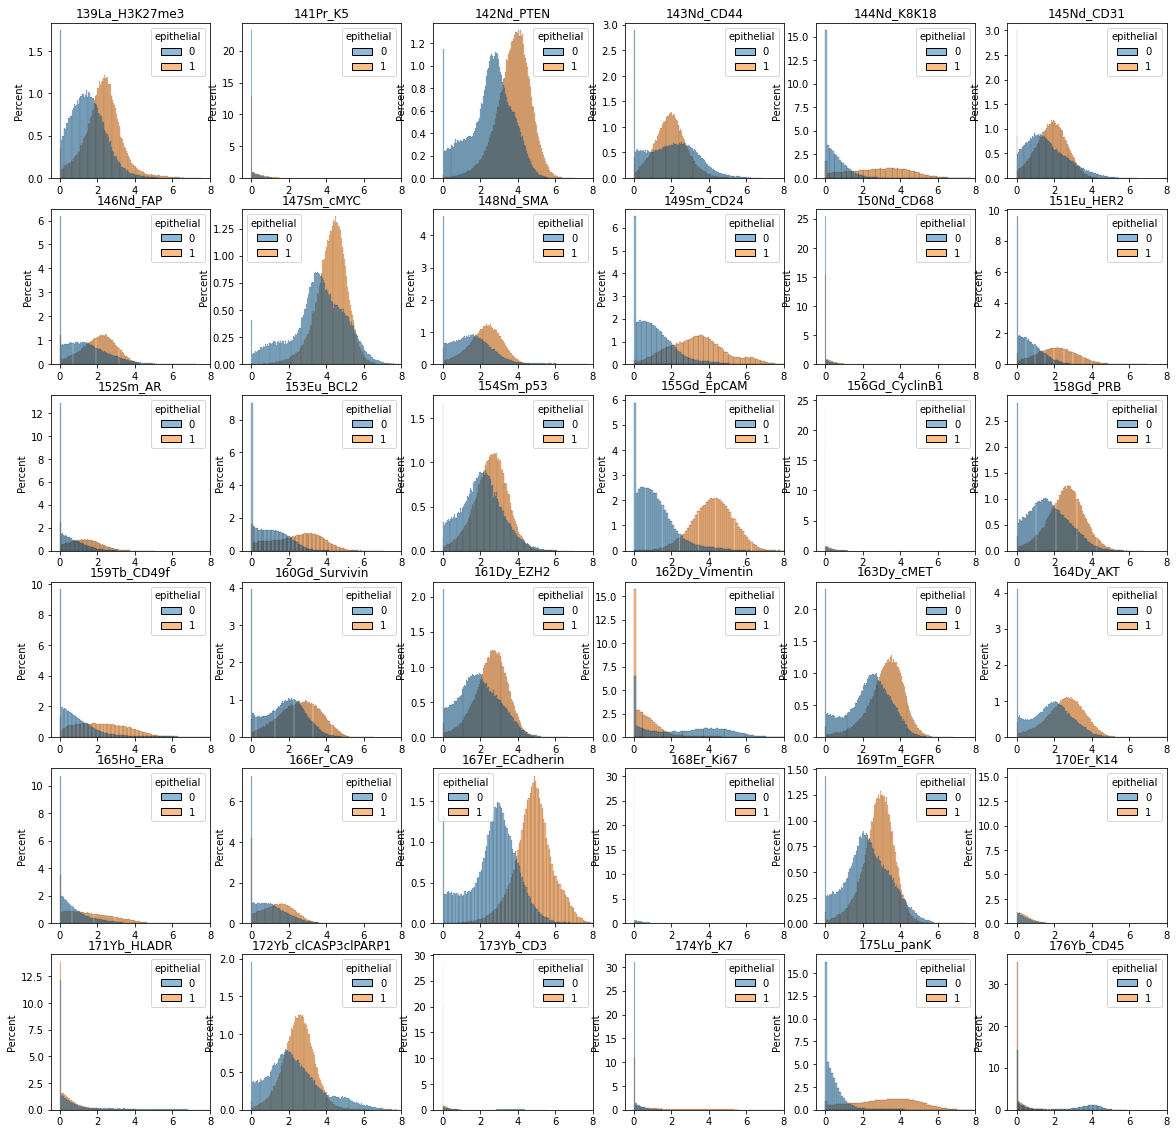

In [17]:
# create a pandas dataframe with data for plotting with seaborn
df=pd.DataFrame(data=ad_anno.layers['arcsinh'], columns=ad_anno.var.desc)
df.insert(0,'epithelial',ad_anno.obs.is_epithelial.values)
# sample 100,000 cells per category
df_plot=df.groupby('epithelial').sample(n=100000) 

fig = plt.figure(figsize=(20,20))
for m in range(1,df_plot.shape[1]):
    plt.subplot(6, 6, m)
    sns.histplot(data=df_plot, x=df_plot.columns[m], hue="epithelial", stat='percent')
    plt.title(df_plot.columns[m])
    plt.xlim([-0.5, 8])
    plt.xlabel('')

#plt.savefig('marker_hist_annotated.pdf', dpi=300)
plt.show()


### Train the neural network classifier
We will next train a simple neural network classifier using the annotated data. We first initialize the model by defining the dimensions of the input layer equal to the number of markers in the training data. By default, the model architecture consists of 1 hidden layer of 20 neurons, (with a ReLU activation function) and one output layer of one neuron (with a softmax activation function). The dataset is randomly split into training (50%), validation (25%), and test (25%) sets. The classifier is trained using the scaled conjugate gradient method, and its performance is evaluated using a standard cross-entropy loss function. We also use an early stopping criterion by terminating training when the model's performance fails to improve for 10 consecutive  runs. For reproducibility, you can also optionally set a `seed`. 

In [18]:
# initialize model and train classifier
clf = scq.EpithelialClassifier(n_in=ad_anno.shape[1], seed=1)
clf.fit(ad_anno, layer='arcsinh_norm', target='is_epithelial', max_epochs=50, seed=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | model            | DefaultCLF       | 782   
1 | loss             | CrossEntropyLoss | 0     
2 | metric_accuracy  | Accuracy         | 0     
3 | metric_precision | Precision        | 0     
------------------------------------------------------
782       Trainable params
0         Non-trainable params
782       Total params
0.003     Total estimated model params size (MB)


/Users/aap/opt/miniconda3/envs/myenv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/aap/opt/miniconda3/envs/myenv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  90%|█████▍| 2175/2417 [00:18<00:02, 115.59it/s, loss=0.329, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 1:  90%|█████▍| 2175/2417 [00:15<00:01, 136.58it/s, loss=0.326, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 2:  90%|█████▍| 2176/2417 [00:16<00:01, 129.96it/s, loss=0.325, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 3:  90%|█████▍| 2176/2417 [00:16<00:01, 133.62it/s, loss=0.325, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 4:  90%|█████▍| 2176/2417 [00:15<00:01, 138.89it/s, loss=0.325, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 5:  90%|█████▍| 2176/2417 [00:15<00:01, 143.30it/s, loss=0.324, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 6:  90%|█████▍| 2176/2417 [00:15<00:01, 141.45it/s, loss=0.323, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 7:  90%|█████▍| 2176/2417 [00:15<00:01, 139.04it/s, loss=0.322, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 8:  90%|█████▍| 2176/2417 [00:15<00:01, 138.88it/s, loss=0.321, v_num=0.1]
Validating: 0it [00:00,

Epoch 10:  90%|█████▍| 2176/2417 [00:15<00:01, 138.69it/s, loss=0.32, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 11:  90%|█████▍| 2176/2417 [00:16<00:01, 133.55it/s, loss=0.32, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 12:  90%|█████▍| 2176/2417 [00:15<00:01, 136.48it/s, loss=0.32, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 13:  90%|█████▍| 2176/2417 [00:15<00:01, 143.49it/s, loss=0.32, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 14:  90%|█████▍| 2176/2417 [00:17<00:01, 126.97it/s, loss=0.32, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 15:  90%|█████▍| 2176/2417 [00:15<00:01, 139.23it/s, loss=0.32, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 16:  90%|█████▍| 2176/2417 [00:16<00:01, 130.98it/s, loss=0.32, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 17:  90%|█████▍| 2176/2417 [00:17<00:01, 125.79it/s, loss=0.32, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 18:  90%|█████▍| 2176/2417 [00:18<00:02, 120.37it/s, loss=0.32, v_num=0.1]
Validating: 0it [00:00,

Epoch 19:  90%|████▌| 2176/2417 [00:15<00:01, 136.51it/s, loss=0.319, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 20:  90%|████▌| 2176/2417 [00:15<00:01, 136.78it/s, loss=0.319, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 21:  90%|████▍| 2175/2417 [00:14<00:01, 147.47it/s, loss=0.319, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 22:  90%|████▍| 2175/2417 [00:14<00:01, 152.30it/s, loss=0.319, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 23:  90%|████▍| 2175/2417 [00:16<00:01, 131.81it/s, loss=0.319, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 24:  90%|████▍| 2175/2417 [00:19<00:02, 112.05it/s, loss=0.319, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 25:  90%|████▍| 2175/2417 [00:14<00:01, 145.57it/s, loss=0.319, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 26:  90%|████▍| 2175/2417 [00:15<00:01, 141.54it/s, loss=0.319, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 27:  90%|████▍| 2175/2417 [00:15<00:01, 137.51it/s, loss=0.319, v_num=0.1]
Validating: 0it [00:00,

Epoch 29:  90%|████▍| 2175/2417 [00:14<00:01, 148.44it/s, loss=0.318, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 30:  90%|████▍| 2175/2417 [00:15<00:01, 141.15it/s, loss=0.319, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 30: 100%|█████| 2417/2417 [00:16<00:00, 148.73it/s, loss=0.319, v_num=0.1]


/Users/aap/opt/miniconda3/envs/myenv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing:  97%|██████████████████████████████ | 261/269 [00:00<00:00, 264.24it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3185671269893646,
 'test_metric_accuracy': 0.9944990873336792,
 'test_metric_precision': 0.9944990873336792}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████| 269/269 [00:00<00:00, 270.75it/s]


By observing the results, we see that the model achieves a 99.4% accuracy and 99.4% precision in the test set. Let's explore the model's performance in more detail by plotting the loss, the confusion matrix and the ROC curve:

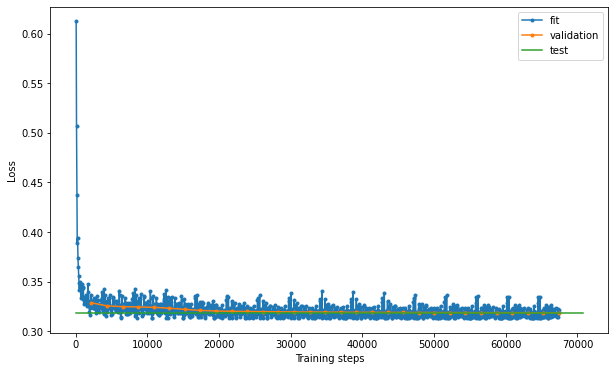

In [67]:
# examine model performance
hist = clf.logger.history
fit_loss = pd.DataFrame.from_records(hist['fit_loss'], columns=['step', 'loss']).assign(stage='fit')
val_loss = pd.DataFrame.from_records(hist['val_loss'], columns=['step', 'loss']).assign(stage='validation')
test_loss = pd.DataFrame.from_records(hist['test_loss'], columns=['step', 'loss']).assign(stage='test')
loss = pd.concat((fit_loss, val_loss, test_loss))
loss = loss.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10,6))
for stage in ['fit', 'validation', 'test']:
    if stage == 'test':
        ax.plot([0, ax.get_xlim()[1]], [loss[loss.stage == stage].loss, loss[loss.stage == stage].loss], label='test')
    else:
        ax.plot(loss[loss.stage == stage].step, loss[loss.stage == stage].loss, '.-', label=stage)
plt.xlabel('Training steps')
plt.ylabel('Loss')
ax.legend()
#plt.savefig('loss.pdf', dpi=300)


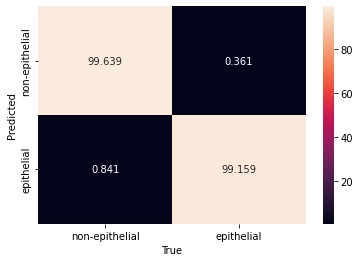

In [20]:
# %% confusion matrix
dl = clf.datamodule.test_dataloader()
data = dl.dataset.dataset.data
y = dl.dataset.dataset.targets.argmax(axis=1)
yhat = clf.model(data)

m = confusion_matrix(y, yhat, normalize='pred')
m = pd.DataFrame(m, columns=['non-epithelial', 'epithelial'], index=['non-epithelial', 'epithelial'])
m.index.name = 'True'
m.columns.name = 'Predicted'
sns.heatmap(m.T * 100, annot=True, fmt='.3f');
#plt.savefig('confusion.pdf', dpi=300)

plt.show()

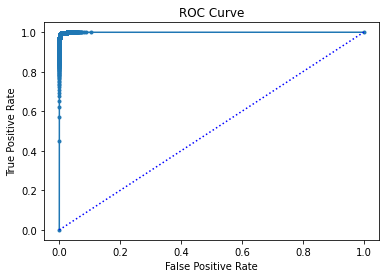

In [21]:
# %% plot ROC curve
yhat = clf.model(data).numpy()
yhat1 = clf.model.model(data).detach().numpy()  # here we access the actual pytorch model
tmp = np.array([yhat1[i][yhat[i]] for i in range(len(yhat))])
score = np.zeros_like(yhat, dtype=float) - 1
score[yhat == 1] = tmp[yhat == 1]
score[yhat == 0] = (1 - tmp[yhat == 0])
fpr, tpr, thresholds = roc_curve(y, score)
plt.plot(fpr, tpr, '.-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'b:')
plt.title('ROC Curve')
#plt.savefig('roc.pdf', dpi=300)

plt.show()

### Classify whole dataset
Once we are confident about the model performance, we can feed the whole dataset to the classifier to predict the epithelial cells:

In [22]:
# prepare the whole dataset for celltype classification
mask = []
for m in marker:
    mask.append(ad.var.desc.str.contains(m))
mask = pd.concat(mask, axis=1)
mask = mask.any(1)
ad.var['used_in_clf'] = mask
ad_pred = ad[:, ad.var.used_in_clf]
X = ad_pred.X.copy()

# arcsinh transformation and minmax scaling
cofactor = 5
np.divide(X, cofactor, out=X)
np.arcsinh(X, out=X)
ad_pred.layers['arcsinh'] = X
X = minMax.transform(X)
ad_pred.layers['arcsinh_norm'] = X

# feed the data to the classifier
clf.predict(ad_pred, layer='arcsinh_norm')
ad.obs['is_epithelial'] = ad_pred.obs.clf_is_epithelial.values

In [23]:
ad.obs['is_epithelial'].value_counts()

0    9407212
1    3977616
Name: is_epithelial, dtype: int64

Since we do not have cell-level annotations for the large dataset, to evaluate the results we can simply plot all marker distributions and cross-compare them with the annotated dataset:

In [24]:
# create pandas dataframes for plotting with seaborn
df1=pd.DataFrame(data=ad_anno.layers['arcsinh'], columns=ad_anno.var.desc)
df1.insert(0,'annotated','true')
df1.insert(0,'epithelial',ad_anno.obs.is_epithelial.values)
df_plot1=df1.groupby('epithelial').sample(n=100000) 

df2=pd.DataFrame(data=ad_pred.layers['arcsinh'], columns=ad_pred.var.desc)
df2.insert(0,'annotated','predicted')
df2.insert(0,'epithelial',ad_pred.obs.clf_is_epithelial.values)
df_plot2=df2.groupby('epithelial').sample(n=100000) 
df_plot = pd.concat([df_plot1, df_plot2])
df_plot=df_plot.sample(frac=1, replace=False, ignore_index=True)
multilabel = df_plot["epithelial"].astype(str) + df_plot["annotated"]
le = preprocessing.LabelEncoder()
multilabel_int=le.fit_transform(multilabel.values)


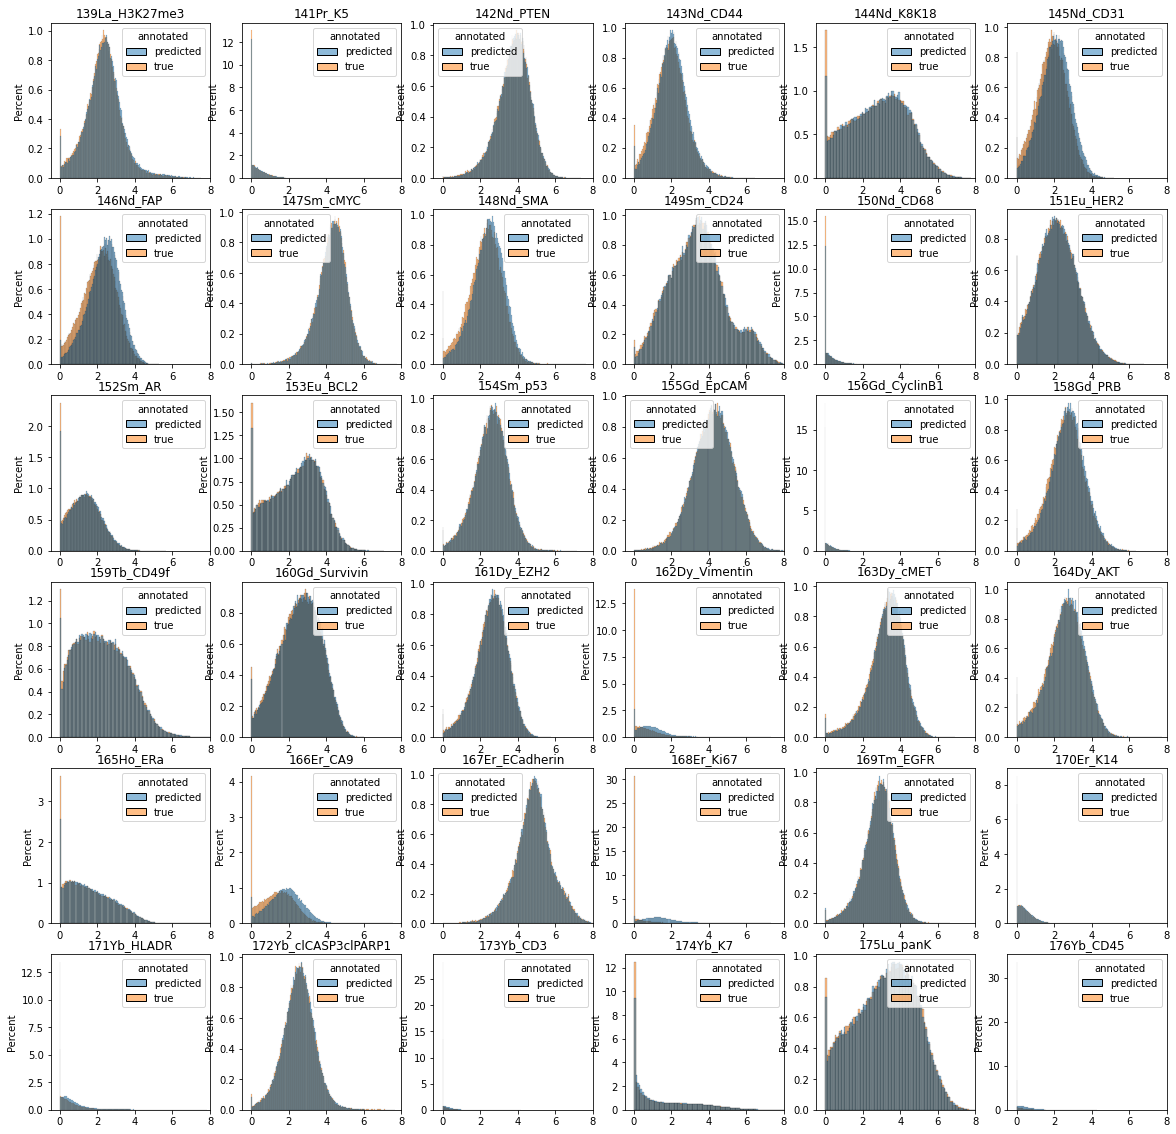

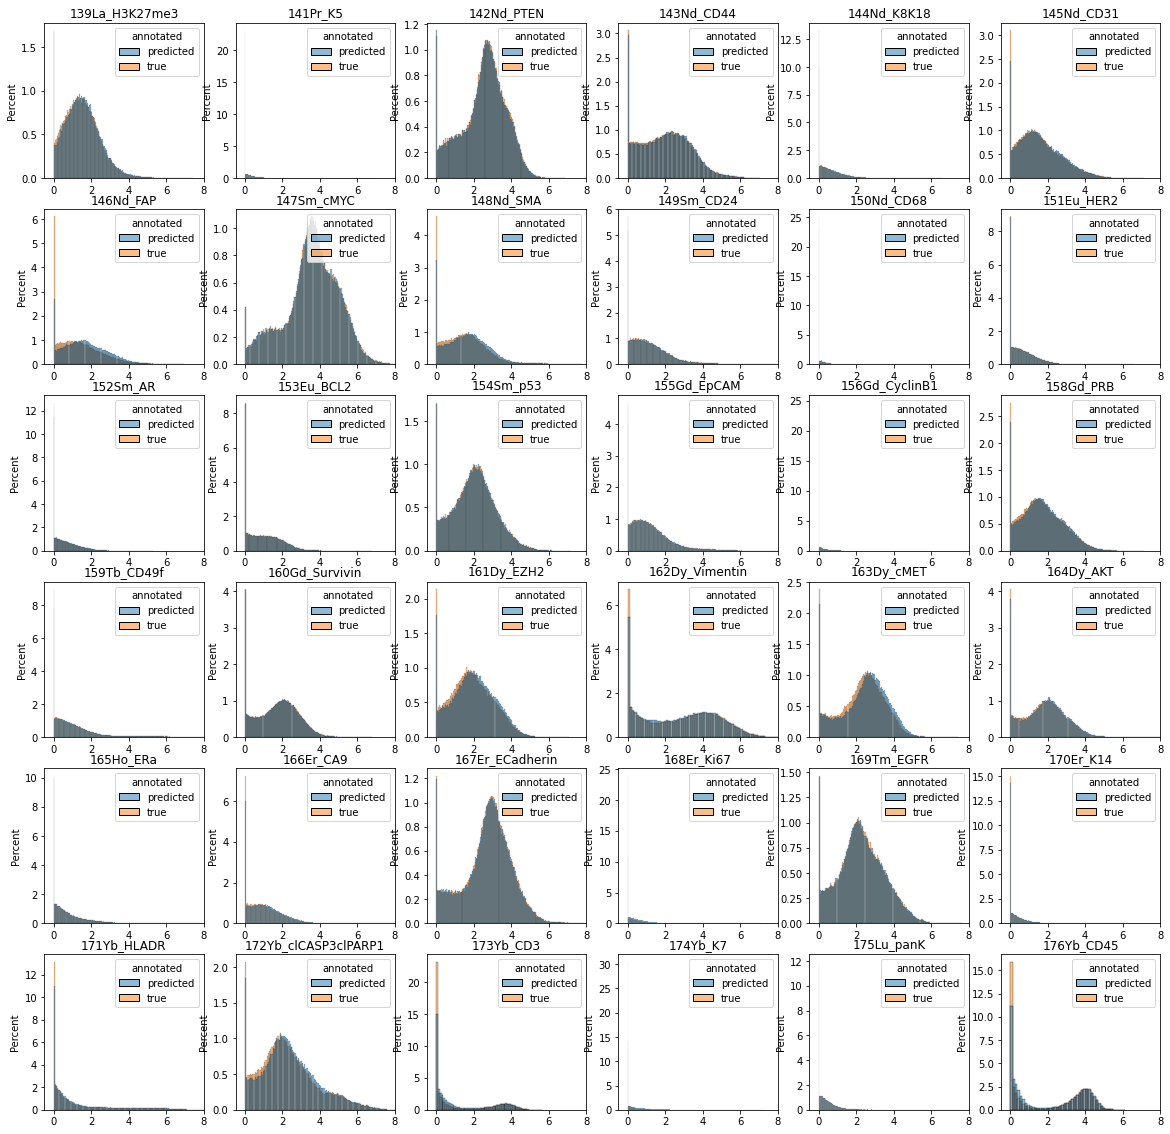

In [25]:
# plot marker distributions across all epithelial cells (predicted vs. annotated)
data=df_plot[df_plot['epithelial']==1].iloc[:,1:].reset_index(drop=True)
fig = plt.figure(figsize=(20,20))
for m in range(1,data.shape[1]):
    plt.subplot(6, 6, m)
    sns.histplot(data=data, 
                 x=data.columns[m], hue="annotated", stat='percent')
    plt.title(data.columns[m])
    plt.xlim([-0.5, 8])
    plt.xlabel('')
plt.show()

# plot marker distributions across all non-epithelial cells (predicted vs. annotated)
data=df_plot[df_plot['epithelial']==0].iloc[:,1:].reset_index(drop=True)
fig = plt.figure(figsize=(20,20))
for m in range(1,data.shape[1]):
    plt.subplot(6, 6, m)
    sns.histplot(data=data, 
                 x=data.columns[m], hue="annotated", stat='percent')
    plt.title(data.columns[m])
    plt.xlim([-0.5, 8])
    plt.xlabel('')
plt.show()

In [27]:
import umap as umap
Y1 = umap.UMAP(n_neighbors=50, min_dist=0.5, metric='euclidean').fit_transform(df_plot.iloc[:,2:])

ImportError: Numba needs NumPy 1.21 or less

In [ ]:
fig = plt.figure(figsize=(10, 8))
sns.scatterplot(Y1[:,0],Y1[:,1],s=1, hue=multilabel_int, 
                   palette=['blue','lightblue', 'orange', 'peachpuff'])
plt.xticks([])
plt.yticks([])
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.savefig('umap.png', dpi=300)
plt.show()

In [ ]:
del ad_pred
del ad_anno

Finally, we can plot the proportion of epithelial cells per sample, and categorize per tissue type as below:

<AxesSubplot:xlabel='tissue_type', ylabel='is_epithelial'>

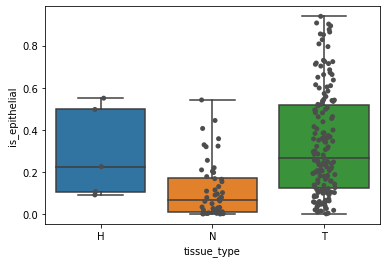

In [28]:
# %% plot fraction of epithelial cells
data = ad.obs.copy()
frac_epith = data.groupby(
    ['tissue_type', 'breast', 'patient_number']).is_epithelial.mean().dropna().reset_index()
fig, ax = plt.subplots()
sns.boxplot(y='is_epithelial', x='tissue_type', data=frac_epith, ax=ax, whis=[0, 100])
sns.stripplot(y='is_epithelial', x='tissue_type', data=frac_epith, ax=ax, color=".3")


## Step 3: Phenotypic abnormality

### Prepare dataset
Let's start by first selecting a list of patients that will be used as a reference input dataset to train the Abnormality autoencoder. Here, we are using only patients for which we have both a juxta-tumoral and tumor sample. If using the protocol for other applications, examples of samples used are reference could be normal vs. disease, non-treatment vs. treatment, etc. We then select a set of markers that will be the features of the input data. 

In [60]:
patients = ['N_BB013', 'N_BB028', 'N_BB034', 'N_BB035', 'N_BB037', 'N_BB046', 'N_BB051', 'N_BB055', 'N_BB058',
            'N_BB064', 'N_BB065', 'N_BB072', 'N_BB073', 'N_BB075', 'N_BB076', 'N_BB090', 'N_BB091', 'N_BB093', 
            'N_BB094', 'N_BB096', 'N_BB099', 'N_BB101', 'N_BB102', 'N_BB110', 'N_BB120', 'N_BB131', 'N_BB144', 
            'N_BB147', 'N_BB153', 'N_BB154', 'N_BB155', 'N_BB167', 'N_BB192', 'N_BB194', 'N_BB197', 'N_BB201', 
            'N_BB204', 'N_BB209', 'N_BB210', 'N_BB214', 'N_BB221']
patients = [i.split('N_')[1] for i in patients]

markers = set(['Vol7', 'H3K27me3', 'K5', 'PTEN', 'CD44', 'K8K18', 'cMYC', 'SMA', 'CD24', 'HER2', 'AR', 'BCL2', 'p53',
     'EpCAM', 'CyclinB1','PRB', 'CD49f', 'Survivin', 'EZH2', 'Vimentin', 'cMET', 'AKT', 'ERa', 'CA9', 
     'ECadherin', 'Ki67', 'EGFR','K14', 'HLADR', 'K7', 'panK'])
drop_markers = set(['Vol7', 'H3K27me3', 'CyclinB1', 'Ki67'])
markers = markers - drop_markers

mask = []
for m in markers:
    mask.append(ad.var.desc.str.contains(m))
mask = pd.concat(mask, axis=1)
mask = mask.any(1)
ad.var['used_in_abnormality'] = mask

Next, subset the whole dataset to only include epithelial cells from the selected patients and juxta-tumoral (N) tissue, and preprocess the data as before:

In [66]:
ad_train = ad[
    (ad.obs.patient_number.isin(patients)) & (ad.obs.tissue_type == 'N') & (ad.obs.is_epithelial == 1),
    ad.var.used_in_abnormality]

X = ad_train.X.copy()
cofactor = 5
np.divide(X, cofactor, out=X)
np.arcsinh(X, out=X)
minMax = MinMaxScaler()
X = minMax.fit_transform(X)
ad_train.layers['arcsinh_norm'] = X

### Train the abnormality Autoencoder

In [142]:
# Initialize and fit the model
Abn = scq.Abnormality(n_in=ad_train.shape[1])
Abn.fit(ad_train, layer='arcsinh_norm', max_epochs=50)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name                    | Type             | Params
-------------------------------------------------------------
0 | model                   | DefaultAE        | 650   
1 | loss                    | MSELoss          | 0     
2 | metric_meansquarederror | MeanSquaredError | 0     
-------------------------------------------------------------
650       Trainable params
0         Non-trainable params
650       Total params
0.003     Total estimated model params size (MB)


/Users/aap/opt/miniconda3/envs/myenv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/aap/opt/miniconda3/envs/myenv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  90%|██████▎| 706/785 [00:05<00:00, 121.10it/s, loss=0.0108, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 1:  90%|██████▎| 706/785 [00:04<00:00, 164.49it/s, loss=0.0104, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 2:  90%|██████▎| 706/785 [00:04<00:00, 157.53it/s, loss=0.0103, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 3:  90%|██████▎| 706/785 [00:04<00:00, 166.08it/s, loss=0.0103, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 4:  90%|██████▎| 706/785 [00:04<00:00, 174.26it/s, loss=0.0103, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 5:  90%|██████▎| 706/785 [00:04<00:00, 168.76it/s, loss=0.0102, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 6:  90%|██████▎| 706/785 [00:04<00:00, 175.98it/s, loss=0.0102, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 7:  90%|██████▎| 706/785 [00:03<00:00, 178.00it/s, loss=0.0102, v_num=0.1]
Validating: 0it [00:00, ?it/s]
Epoch 8:  90%|██████▎| 706/785 [00:04<00:00, 168.14it/s, loss=0.0102, v_num=0.1]
Validating: 0it [00:00,

/Users/aap/opt/miniconda3/envs/myenv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing:  59%|███████████████████▌             | 52/88 [00:00<00:00, 519.58it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.010134579613804817,
 'test_metric_meansquarederror': 50.380104064941406}
--------------------------------------------------------------------------------
Testing: 100%|█████████████████████████████████| 88/88 [00:00<00:00, 518.38it/s]


/var/folders/5n/mh72m7z95tv0lnwc9tc6z75h0000gn/T/ipykernel_21074/51024260.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


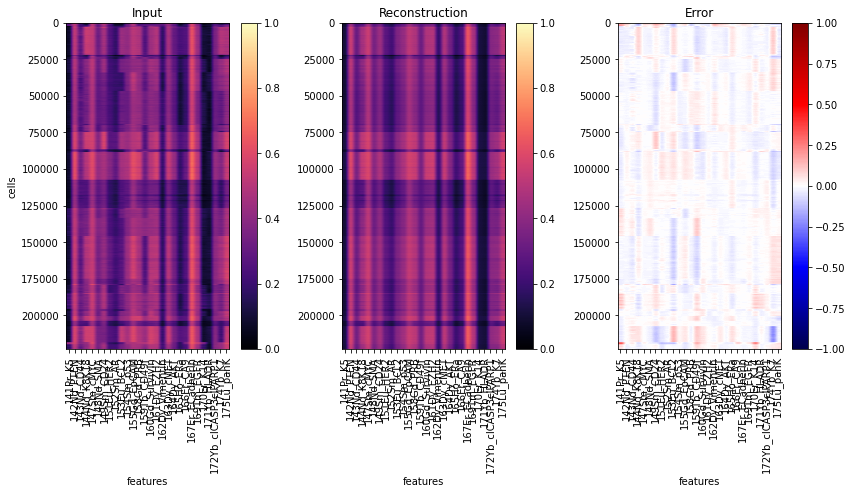

In [166]:
# estimate reconstruction error on the training data
Abn.predict(ad_train, layer='arcsinh_norm')  # where should I save the results in the AnnData? layers or obsm?
mse_train = (ad_train.layers['abnormality'] ** 2).mean(axis=1)
ad_train.obs['abnormality'] = mse_train

y = ad_train.layers['arcsinh_norm']
yhat = Abn.model.model(torch.tensor(y)).detach().numpy()  # access base torch model
err = ad_train.layers['abnormality']

fig, axs = plt.subplots(1, 3, figsize=(14,6))
for ax, dat, title in zip(axs.flat, [y, yhat, err], ['Input', 'Reconstruction', 'Error']):
    ax: plt.Axes
    cmap = 'seismic' if title == 'Error' else 'magma'
    vmin = -1 if title == 'Error' else 0
    im = ax.imshow(dat, cmap=cmap, vmin=vmin, vmax=1)
    ax.set_aspect(dat.shape[1] *2 / dat.shape[0])
    ax.set_xticks(range(28), labels=ad_pred.var['desc'].values, rotation='vertical')
    ax.set_xlabel('features')
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
axs[0].set_ylabel('cells')
fig.show()

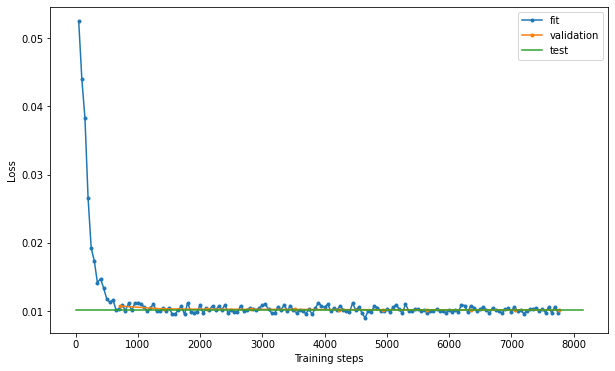

In [146]:
hist = Abn.logger.history
fit_loss = pd.DataFrame.from_records(hist['fit_loss'], columns=['step', 'loss']).assign(stage='fit')
val_loss = pd.DataFrame.from_records(hist['val_loss'], columns=['step', 'loss']).assign(stage='validation')
test_loss = pd.DataFrame.from_records(hist['test_loss'], columns=['step', 'loss']).assign(stage='test')
loss = pd.concat((fit_loss, val_loss, test_loss))
loss = loss.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10,6))
for stage in ['fit', 'validation', 'test']:
    if stage == 'test':
        ax.plot([0, ax.get_xlim()[1]], [loss[loss.stage == stage].loss, loss[loss.stage == stage].loss], label='test')
    else:
        ax.plot(loss[loss.stage == stage].step, loss[loss.stage == stage].loss, '.-', label=stage)
plt.xlabel('Training steps')
plt.ylabel('Loss')
ax.legend()


### Reconstruct all cells
Now let's use the model to reconstruct all epithelial data and compute the mean squared error of the reconstrucction: 

In [147]:
# %% pre-process for Abnormality prediction
ad_pred = ad[ad.obs.is_epithelial == 1, ad.var.used_in_abnormality]
X = ad_pred.X.copy()
cofactor = 5
np.divide(X, cofactor, out=X)
np.arcsinh(X, out=X)
X = minMax.transform(X)
ad_pred.layers['arcsinh_norm'] = X

# estimate reconstruction error
Abn.predict(ad_pred, layer='arcsinh_norm')  # where should I save the results in the AnnData? layers or obsm?
mse = (ad_pred.layers['abnormality'] ** 2).mean(axis=1)
ad_pred.obs['abnormality'] = mse

To evaluate the results, let's reconstruct all single-cells and visualize the prediction residuals:

/var/folders/5n/mh72m7z95tv0lnwc9tc6z75h0000gn/T/ipykernel_21074/2985082577.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


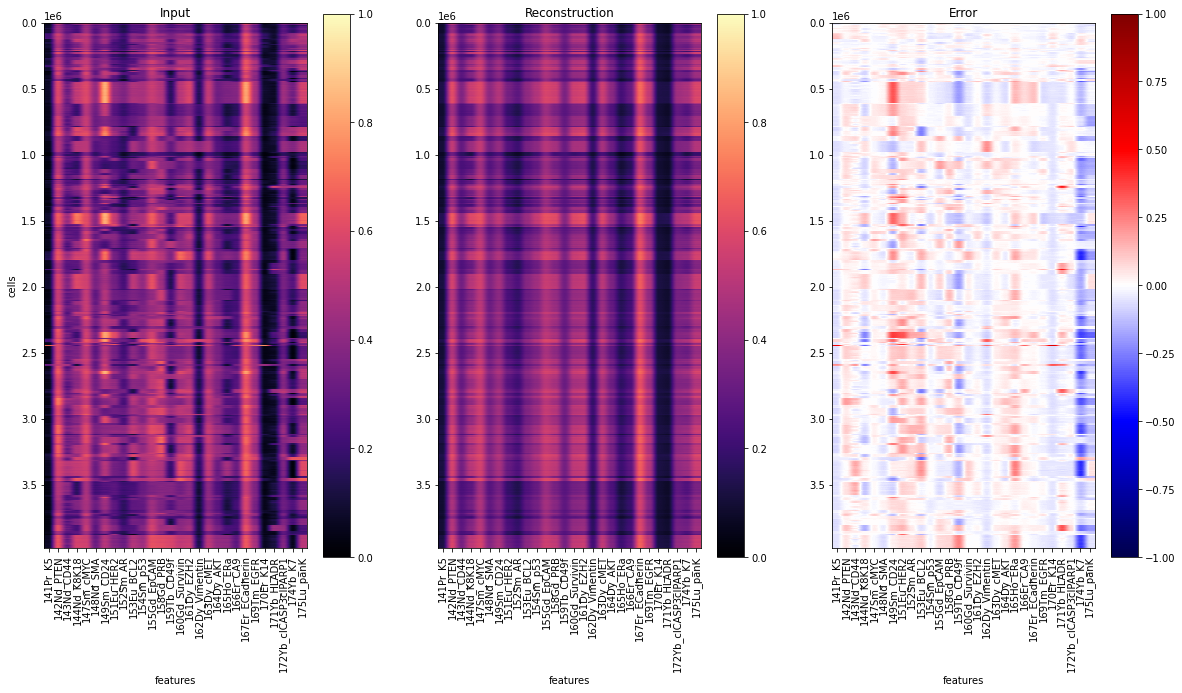

In [171]:
y = ad_pred.layers['arcsinh_norm']
yhat = Abn.model.model(torch.tensor(y)).detach().numpy()  # access base torch model
err = ad_pred.layers['abnormality']

fig, axs = plt.subplots(1, 3, figsize=(20,10))
for ax, dat, title in zip(axs.flat, [y, yhat, err], ['Input', 'Reconstruction', 'Error']):
    ax: plt.Axes
    cmap = 'seismic' if title == 'Error' else 'magma'
    vmin = -1 if title == 'Error' else 0
    im = ax.imshow(dat, cmap=cmap, vmin=vmin, vmax=1)
    plt.hlines([])
    ax.set_aspect(dat.shape[1] *2 / dat.shape[0])
    ax.set_xticks(range(28), labels=ad_pred.var['desc'].values, rotation='vertical')
    ax.set_xlabel('features')
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
axs[0].set_ylabel('cells')
plt.savefig('reconstruction.pdf', dpi=300)
fig.show()

Now let's visualize the error per tissue type:

/var/folders/5n/mh72m7z95tv0lnwc9tc6z75h0000gn/T/ipykernel_21074/1166979739.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


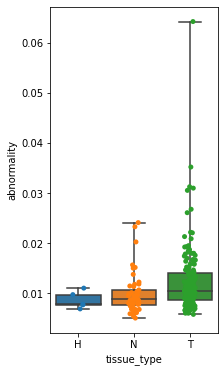

In [176]:
dat = ad_pred.obs.groupby(['tissue_type','breast','patient_number']).abnormality.agg(np.median).dropna().reset_index()

fig, ax = plt.subplots(figsize=(3,6))
sns.boxplot(data=dat, x='tissue_type', y='abnormality', ax=ax, whis=[0, 100])
sns.stripplot(data=dat, x='tissue_type', y='abnormality', ax=ax)
fig.show()

In [182]:
ad_pred.obs.groupby(['tissue_type', 'breast', 'patient_number']).abnormality.agg(np.median).dropna().reset_index()

,tissue_type,breast,patient_number,abnormality
0,H,,BB095,0.007712
1,H,L,BB239,0.006908
2,H,L,BB242,0.009757
3,H,R,BB239,0.007834
4,H,R,BB242,0.011050
...,...,...,...,...
206,T,,BB235,0.007929
207,T,,BB236,0.014679
208,T,,BB237,0.017859
209,T,,BB238,0.012362


In [203]:
ad_pred.obs

,tissue_type,patient_number,breast,tumor_region,plate,plate_location,gadolinium_status,fcs_file,Time,EventLength,Center,Offset,Width,Residual,beadDist,is_epithelial,abnormality
27,H,BB095,,,Plate1,2-D2,neg,H_BB095_Plate1_2-D2_GDneg.fcs,1.803590e+04,12.0,451.627655,83.871559,29.875830,33.550922,71.286644,1,0.007261
33,H,BB095,,,Plate1,2-D2,neg,H_BB095_Plate1_2-D2_GDneg.fcs,2.160396e+04,13.0,390.254364,57.575741,22.148920,107.174538,65.994003,1,0.011099
34,H,BB095,,,Plate1,2-D2,neg,H_BB095_Plate1_2-D2_GDneg.fcs,2.164451e+04,14.0,435.328583,66.744713,26.987694,55.551529,65.994240,1,0.006310
37,H,BB095,,,Plate1,2-D2,neg,H_BB095_Plate1_2-D2_GDneg.fcs,2.423453e+04,13.0,424.515106,86.164703,33.154839,27.398260,86.873909,1,0.007172
39,H,BB095,,,Plate1,2-D2,neg,H_BB095_Plate1_2-D2_GDneg.fcs,2.461900e+04,12.0,435.409271,125.901756,43.621136,72.282738,77.127953,1,0.004836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13384821,T,BB241,,,Plate1,2-E11,neg,T_BB241_Plate1_2-E11_GDneg.fcs,2.796354e+08,14.0,603.588928,100.724167,41.415195,22.611845,66.564758,1,0.015960
13384822,T,BB241,,,Plate1,2-E11,neg,T_BB241_Plate1_2-E11_GDneg.fcs,2.796354e+08,15.0,614.945496,96.265076,42.488716,45.888901,57.546806,1,0.017665
13384823,T,BB241,,,Plate1,2-E11,neg,T_BB241_Plate1_2-E11_GDneg.fcs,2.796360e+08,15.0,565.087280,92.526543,41.000614,60.363697,75.759628,1,0.020069
13384824,T,BB241,,,Plate1,2-E11,neg,T_BB241_Plate1_2-E11_GDneg.fcs,2.796375e+08,14.0,483.737701,83.420410,34.364201,70.602890,82.121452,1,0.028075


## Tumor individuality

In [ ]:
# individuality preprocessing
ad_indiv = ad[:, ad.var.used_in_abnormality]
X = ad_indiv.X.copy()
cofactor = 5
np.divide(X, cofactor, out=X)
np.arcsinh(X, out=X)
ad_indiv.layers['arcsinh'] = X

ad_indiv.obs['sample_id'] = ad_indiv.obs.groupby(['tissue_type', 'breast', 'patient_number']).ngroup()

# %% sub-sample
tmp = ad_indiv.obs.groupby(['sample_id']).indices
n_cells = 200
indices = []
for key, item in tmp.items():
    size = min(len(item), n_cells)
idx = np.random.randint(0, len(item), size)
indices.extend(item[idx])
indices = np.array(indices)
ad_indiv = ad_indiv[indices]

In [ ]:
ad_indiv

In [ ]:
# %%
Indiv = sp.Individuality()
Indiv.predict(ad_indiv, ad_indiv.obs.sample_id, layer='arcsinh')

# ad.obsm['individuality']
# ad.uns['individuality_agg']

# %%
dat = ad_indiv.uns['individuality_agg'].copy()
dat = pd.DataFrame(np.diag(dat), index=dat.index, columns=['individuality'])
# ad.obsm['individuality']

mapping = ad_indiv.obs[['tissue_type', 'breast', 'patient_number', 'sample_id']].set_index(
    'sample_id').to_dict()
dat['breast'] = dat.index.map(mapping['breast'])
dat['tissue_type'] = dat.index.map(mapping['tissue_type'])
dat['patient_number'] = dat.index.map(mapping['patient_number'])

# %%

fig, ax = plt.subplots()
sns.boxplot(data=dat, x='tissue_type', y='individuality', ax=ax, whis=[0, 100])
sns.stripplot(data=dat, x='tissue_type', y='individuality', ax=ax)
fig.show()


In [ ]:

# %% set up example with custom AE model and datamodule
import starProtocols as sp
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

import torchmetrics
import pytorch_lightning as pl

class MyTorchModel(nn.Module):

    def __init__(self, n_in: int):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(n_in, 20), nn.ReLU(),
                                   nn.Linear(20, 10), nn.ReLU(),
                                   nn.Linear(10, 2), nn.ReLU(),
                                   nn.Linear(2, 10), nn.ReLU(),
                                   nn.Linear(10, 20), nn.ReLU(),
                                   nn.Linear(20, n_in), nn.Sigmoid())

    def forward(self, x):
        return self.model(x)


class MyLightningModule(pl.LightningModule):
    def __init__(self, n_in: int):
        super().__init__()
        self.model = MyTorchModel(n_in=n_in)
        self.loss = nn.MSELoss()
        self.metric_mse = torchmetrics.MeanSquaredError()

    def forward(self, x):
        return x - self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)  # self(x) would call self.forward(x)
        loss = self.loss(y_hat, y)
        self.log('train_mse', self.metric_mse(y_hat, y))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)  # self(x) would call self.forward(x)
        loss = self.loss(y_hat, y)
        self.log('val_mse', self.metric_mse(y_hat, y))
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)  # self(x) would call self.forward(x)
        loss = self.loss(y_hat, y)
        self.log('test_mse', self.metric_mse(y_hat, y))
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


class MyDataset(Dataset):
    def __init__(self, X):
        super().__init__()
        self.data = torch.tensor(X).float()

    def __getitem__(self, item):
        return self.data[item], self.data[item]

    def __len__(self):
        return len(self.data)


class MyDataModule(pl.LightningDataModule):
    def __init__(self, dataset, test_size: float = 0.2, validation_size: float = 0.1, batch_size: int = 256,
                 shuffle=True):
        super().__init__()
        l = len(dataset)

        dataset.data = dataset.data[
            torch.randperm(len(dataset))] if shuffle else dataset.data  # this has a side-effect on dataset!
        self.ds: Dataset = dataset

        self.test_size = int(test_size * l)
        self.train_size = l - self.test_size
        self.validation_size = int(self.train_size * validation_size)
        self.fit_size = self.train_size - self.validation_size

        self.batch_size = batch_size

    def setup(self, stage=None):
        self.fit, self.test = random_split(self.ds, [self.train_size, self.test_size])
        self.fit, self.validation = random_split(self.fit, [self.fit_size, self.validation_size])

    def train_dataloader(self):
        return DataLoader(self.fit, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.validation, batch_size=self.batch_size, shuffle=True)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, shuffle=True)


# %% custom AE example continued

# data
ad = sp.dataset.breastCancerAtlas()
ad = ad[(ad.obs.celltype_class == 'epithelial') & (ad.obs.tissue_type == 'N'), :10]

# convert to torch dataset
ds = MyDataset(ad.X)

# convert to lightning datamodule
dm = MyDataModule(ds, batch_size=128)

# lightning module
module = MyLightningModule(n_in=ad.shape[1])
print(module)

# training with custom model and data
Abn = sp.Abnormality(model=module)
Abn.fit(datamodule=dm, early_stopping=[], max_epochs=1)